In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sma
import statsmodels.formula.api as smf
import sklearn.linear_model as lm
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score)
# set up path to import my python scripts
import sys
import os
src_path = os.path.abspath(os.path.join('..'))
if src_path not in sys.path:
    sys.path.append(src_path+"/src")
    
%load_ext autoreload
%autoreload 2
import clean_df

#import data from 2013-2014 NHANES: https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey
#description of columns: https://wwwn.cdc.gov/nchs/nhanes/2013-2014/demo_h.htm
demo_df = pd.read_csv('../data/demographic.csv')
diet_df = pd.read_csv('../data/diet.csv')
exam_df = pd.read_csv('../data/examination.csv')
labs_df = pd.read_csv('../data/labs.csv')
med_df = pd.read_csv('../data/medications.csv', encoding='latin1')
ques_df = pd.read_csv('../data/questionnaire.csv')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Step 1: EDA

In [2]:
new_demo_df = demo_df[['SEQN','RIAGENDR','RIDAGEYR','RIDRETH3',
'DMQMILIZ','DMQADFC','DMDBORN4','DMDMARTL']]

In [3]:
'''
demo_df feature descriptions:
------------------------------
SEQN: Participant sequence number
RIAGENDR: Particpant gender
	1 -> Male
	2 -> Female
RIDAGEYR: Age in years
RIDRETH3: Race/Hispanic origin w/ NH Asian
	1 -> Mexican American
	2 -> Other Hispanic
	3 -> Non-Hispanic White
	4 -> Non-Hispanic Black
	6 -> Non-Hispanic Asian
	7 -> Other Race - Including Multi-Racial
DMQMILIZ: Served active duty in US Armed Forces
	1 -> Yes
	2 -> No
	7 -> Refused
	9 -> Don't Know
	. -> Missing
DMQADFC: Served in a foreign country
	1 -> Yes
	2 -> No
	7 -> Refused
	9 -> Don't Know
	. -> Missing
DMDBORN4: Country of birth
	1 -> Born in US
	2 -> Others
	77 -> Refused
	99 -> Don't Know
	. -> Missing
DMDMARTL: Marital Status
	1 -> Married
	2 -> Widowed
	3 -> Divorced
	4 -> Separated
	5 -> Never married
	6 -> Living with partner
	77 -> Refused
	99 -> Don't Know
	. -> Missing
'''

"\ndemo_df feature descriptions:\n------------------------------\nSEQN: Participant sequence number\nRIAGENDR: Particpant gender\n\t1 -> Male\n\t2 -> Female\nRIDAGEYR: Age in years\nRIDRETH3: Race/Hispanic origin w/ NH Asian\n\t1 -> Mexican American\n\t2 -> Other Hispanic\n\t3 -> Non-Hispanic White\n\t4 -> Non-Hispanic Black\n\t6 -> Non-Hispanic Asian\n\t7 -> Other Race - Including Multi-Racial\nDMQMILIZ: Served active duty in US Armed Forces\n\t1 -> Yes\n\t2 -> No\n\t7 -> Refused\n\t9 -> Don't Know\n\t. -> Missing\nDMQADFC: Served in a foreign country\n\t1 -> Yes\n\t2 -> No\n\t7 -> Refused\n\t9 -> Don't Know\n\t. -> Missing\nDMDBORN4: Country of birth\n\t1 -> Born in US\n\t2 -> Others\n\t77 -> Refused\n\t99 -> Don't Know\n\t. -> Missing\nDMDMARTL: Marital Status\n\t1 -> Married\n\t2 -> Widowed\n\t3 -> Divorced\n\t4 -> Separated\n\t5 -> Never married\n\t6 -> Living with partner\n\t77 -> Refused\n\t99 -> Don't Know\n\t. -> Missing\n"

In [2]:
new_df = clean_df.DemographicDF()
exam_df = clean_df.ExamDF()
new_df.left_merge(exam_df)
labs_df = clean_df.LabsDF()
new_df.left_merge(labs_df)
ques_df = clean_df.QuestDF()
new_df.left_merge(ques_df)

In [3]:
new_df.df.head()

,SEQN,RIAGENDR,RIDAGEYR,RIDRETH3,DMQMILIZ,DMQADFC,DMDBORN4,DMDMARTL,AVG_SYS_BP,AVG_DIAS_BP,High_SYS_BP,High_DIAS_BP,LBXHCT,LBXTR,BPQ020,BPQ080,BPQ040A,BPQ050A,BPQ090D
0,73557,Male,69,Black,Yes,Yes,Born in US,Separated,112.666667,74.000000,0.0,0.0,45.4,NaN,Yes,Yes,Yes,No,Yes
1,73558,Male,54,White,No,NaN,Born in US,Married,157.333333,61.333333,1.0,0.0,36.7,NaN,Yes,Yes,No,NaN,Yes
2,73559,Male,72,White,Yes,Yes,Born in US,Married,142.000000,82.000000,1.0,1.0,49.9,51.0,Yes,Yes,Yes,Yes,Yes
3,73560,Male,9,White,NaN,NaN,Born in US,NaN,104.666667,36.666667,0.0,0.0,37.8,NaN,NaN,NaN,NaN,NaN,NaN
4,73561,Female,73,White,No,NaN,Born in US,Married,137.333333,86.666667,1.0,1.0,43.8,75.0,Yes,No,Yes,Yes,No


In [4]:
test_df = new_df.df
nicotine = test_df['LBXHCT']
avg_sys_bp = test_df['AVG_SYS_BP']

In [5]:
test_df.loc[test_df['RIDAGEYR'] > -1, ['SEQN']]

,SEQN
0,73557
1,73558
2,73559
3,73560
4,73561
...,...
10170,83727
10171,83728
10172,83729
10173,83730


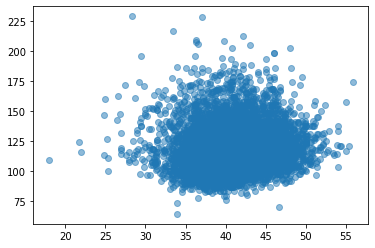

In [6]:
#AVG Systolic BP vs Nicotine (Hydroxycotinine, Serum (ng/mL))
fig, ax = plt.subplots()

# x = test_df['LBXHCT']
# y = test_df['AVG SYS BP']

ax = plt.scatter(x=nicotine,y=avg_sys_bp,alpha=0.5)

plt.show()

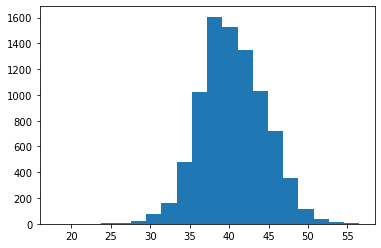

In [7]:
fig, ax = plt.subplots()

ax = plt.hist(x=nicotine,bins=20)

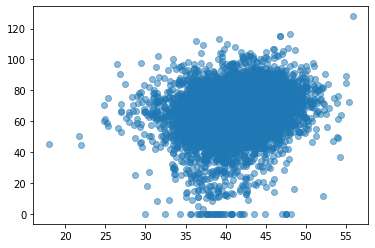

In [8]:
#AVG Diastolic BP vs Nicotine (Hydroxycotinine, Serum (ng/mL))
fig, ax = plt.subplots()

x = test_df['LBXHCT']
y = test_df['AVG_DIAS_BP']

ax = plt.scatter(x=x,y=y,alpha=0.5)

plt.show()

In [9]:
# sns.pairplot(new_df.df)

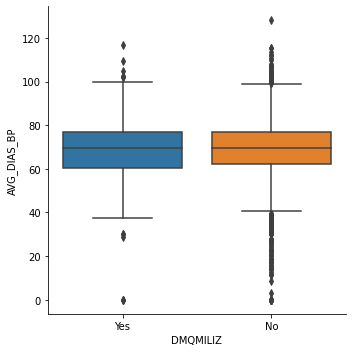

In [10]:
sns.catplot(x='DMQMILIZ', y='AVG_DIAS_BP',kind='box',data=test_df)

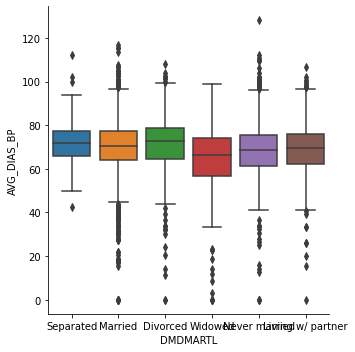

In [11]:
sns.catplot(x='DMDMARTL', y='AVG_DIAS_BP',kind='box', data=test_df)

<AxesSubplot:xlabel='LBXHCT', ylabel='High_DIAS_BP'>

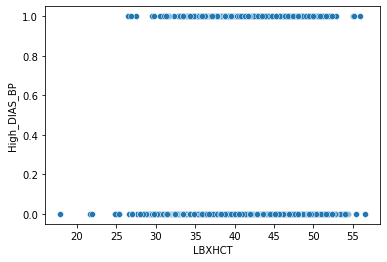

In [12]:
sns.scatterplot(x='LBXHCT', y='High_DIAS_BP',data=test_df)

<AxesSubplot:xlabel='LBXHCT', ylabel='High_SYS_BP'>

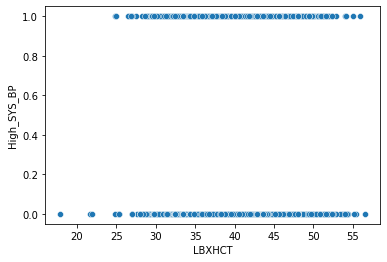

In [13]:
sns.scatterplot(x='LBXHCT', y='High_SYS_BP',data=test_df)

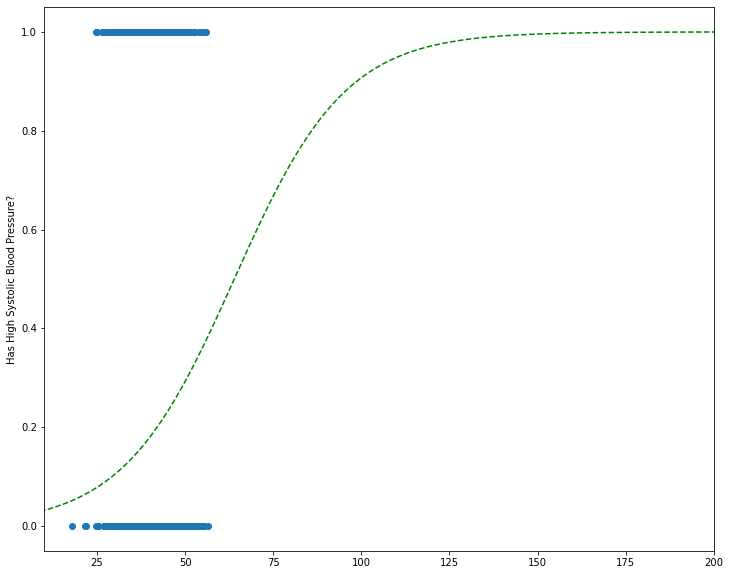

In [93]:
xy_values = test_df[test_df['LBXHCT']>-1]
xy_values = xy_values[xy_values['High_SYS_BP']>-1].sort_values(by='LBXHCT')
x_values = xy_values['LBXHCT'].to_numpy().reshape(-1,1)
y_values = xy_values['High_SYS_BP'].to_numpy().astype('int')

model = lm.LogisticRegression()
results = model.fit(X=x_values,y=y_values)

x = np.linspace(0,500,500).reshape(-1,1)

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
ax.scatter(x_values, y_values, cmap='bwr')
ax.plot(x, model.predict_proba(x)[:,1], 'g--', label='probability of horse')
ax.set_xlim([10,200])
# ax.set_ylim([-0.2,1.201])
# ax.set_xlabel('Weight (lb)',fontsize=font_size)
ax.set_ylabel('Has High Systolic Blood Pressure?')
# ax.set_title('Horseness vs. weight',fontsize=font_size)
plt.show()

Accuracy:  0.3020833333333333
Precision:  0.19467787114845939
Recall:  0.8671241422333126


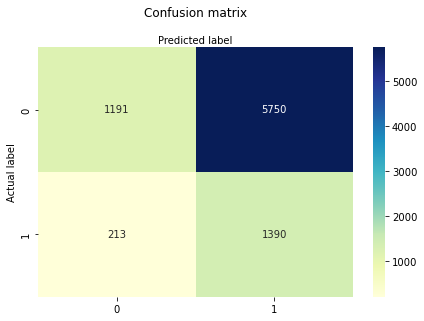

In [81]:
xy_values = test_df[test_df['LBXHCT']>-1]
xy_values = xy_values[xy_values['High_SYS_BP']>-1].sort_values(by='LBXHCT')
x_values = xy_values['LBXHCT'].to_numpy().reshape(-1,1)
y_values = xy_values['High_SYS_BP'].to_numpy().astype('int')

#xy_values.head()
#print(type(y_values))

model = lm.LogisticRegression()
results = model.fit(X=x_values,y=y_values)

y_hat_probs = model.predict_proba(x_values)[:,1]

threshold = 0.15
y_hat_1 = (y_hat_probs >= threshold).astype('int')

cnf_matrix = confusion_matrix(y_values, y_hat_1)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print('Accuracy: ', accuracy_score(y_values, y_hat_1))
print('Precision: ', precision_score(y_values, y_hat_1))
print('Recall: ', recall_score(y_values, y_hat_1))
#print(results.summary())


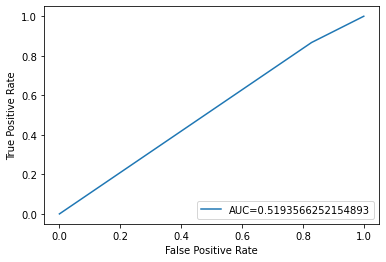

In [88]:
fpr, tpr, _ = roc_curve(y_values,  y_hat_1)
auc = roc_auc_score(y_values, y_hat_1)
#create ROC curve
plt.plot(fpr,tpr,label=f'AUC={auc}')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

Accuracy:  0.6390449438202247
Precision:  0.2438602559667935
Recall:  0.4398003742981909


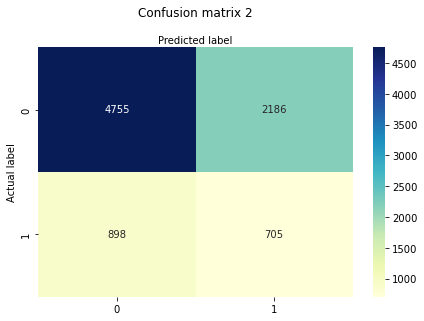

In [84]:
threshold_2 = 0.20
y_hat_2 = (y_hat_probs >= threshold_2).astype('int')

cnf_matrix_2 = confusion_matrix(y_values, y_hat_2)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix_2), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix 2', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print('Accuracy: ', accuracy_score(y_values, y_hat_2))
print('Precision: ', precision_score(y_values, y_hat_2))
print('Recall: ', recall_score(y_values, y_hat_2))

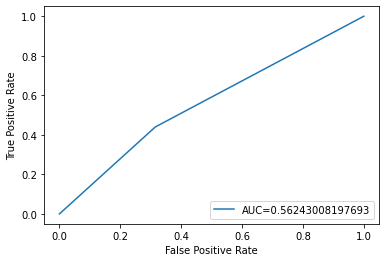

In [89]:
fpr_2, tpr_2, _ = roc_curve(y_values,  y_hat_2)
auc_2 = roc_auc_score(y_values, y_hat_2)

#create ROC curve
plt.plot(fpr_2,tpr_2,label=f'AUC={auc_2}')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

Accuracy:  0.53312265917603
Precision:  0.2328705776981639
Recall:  0.6487835308796007


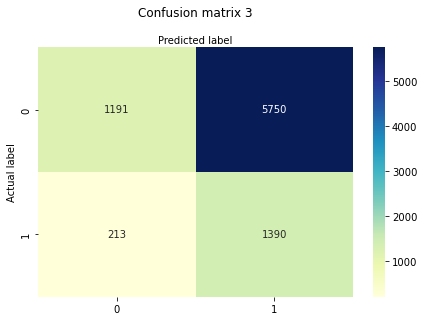

In [91]:
threshold = 0.18
y_hat_3 = (y_hat_probs >= threshold).astype('int')

cnf_matrix_3 = confusion_matrix(y_values, y_hat_3)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix 3', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print('Accuracy: ', accuracy_score(y_values, y_hat_3))
print('Precision: ', precision_score(y_values, y_hat_3))
print('Recall: ', recall_score(y_values, y_hat_3))

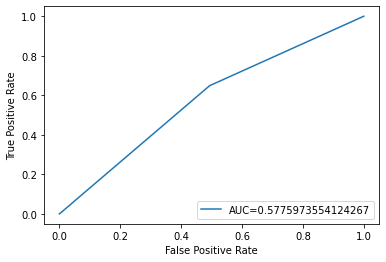

In [92]:
fpr_3, tpr_3, _ = roc_curve(y_values,  y_hat_3)
auc_3 = roc_auc_score(y_values, y_hat_3)

#create ROC curve
plt.plot(fpr_3,tpr_3,label=f'AUC={auc_3}')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

Accuracy:  1.0
Precision:  1.0
Recall:  1.0
[4.21386975e-04 4.21386975e-04 4.21386975e-04 ... 9.97326944e-01
 9.97326944e-01 9.97326944e-01]


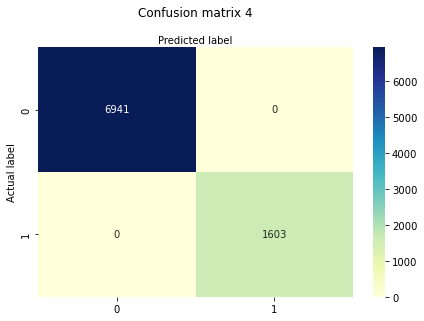

In [107]:
xy_values_2 = test_df[['LBXHCT','RIDAGEYR','High_SYS_BP']]
xy_values_2 = xy_values_2.dropna()
feature_cols = ['RIDAGEYR','High_SYS_BP']
x_values_2 = xy_values_2[feature_cols]
y_values_2 = xy_values_2['High_SYS_BP'].to_numpy().astype('int')

model_4 = lm.LogisticRegression()
results = model_4.fit(X=x_values_2,y=y_values_2)

y_hat_probs = model_4.predict_proba(x_values_2)[:,1]

threshold = 0.5
y_hat_4 = (y_hat_probs >= threshold).astype('int')

cnf_matrix_4 = confusion_matrix(y_values_2, y_hat_4)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix_4), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix 4', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print('Accuracy: ', accuracy_score(y_values_2, y_hat_4))
print('Precision: ', precision_score(y_values_2, y_hat_4))
print('Recall: ', recall_score(y_values_2, y_hat_4))
print(np.sort(y_hat_probs))

# xy_values = xy_values[xy_values['High_SYS_BP']>-1].sort_values(by='LBXHCT')
# x_values = xy_values['LBXHCT'].to_numpy().reshape(-1,1)
# y_values = xy_values['High_SYS_BP'].to_numpy().astype('int')

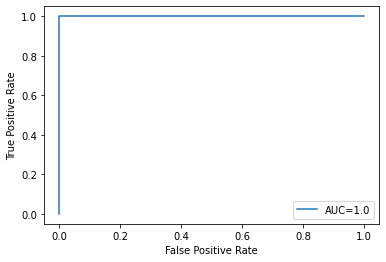

In [108]:
fpr_4, tpr_4, _ = roc_curve(y_values_2,  y_hat_4)
auc_4 = roc_auc_score(y_values_2, y_hat_4)

#create ROC curve
plt.plot(fpr_4,tpr_4,label=f'AUC={auc_4}')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [ ]:
formula2 = "High_SYS_BP ~ LBXHCT + RIDAGEYR"
mylogit2 = smf.logit(formula=formula2, data=test_df).fit()
mylogit2.summary()

In [ ]:
formula3 = "High_SYS_BP ~ LBXHCT + RIDAGEYR + RIAGENDR"
mylogit3 = smf.logit(formula=formula3, data=test_df).fit()
mylogit3.summary()

In [ ]:
formula4 = "High_SYS_BP ~ LBXHCT + RIAGENDR"
mylogit4 = smf.logit(formula=formula4, data=test_df).fit()
mylogit4.summary()

In [ ]:
formula5 = "High_SYS_BP ~ LBXHCT + DMQMILIZ"
mylogit5 = smf.logit(formula=formula5, data=test_df).fit()
mylogit5.summary()

In [ ]:
formula6 = "High_SYS_BP ~ DMQMILIZ"
mylogit6 = smf.logit(formula=formula6, data=test_df).fit()
mylogit6.summary()

In [ ]:
xy_values = test_df[test_df['LBXHCT']>-1]
xy_values = xy_values[xy_values['High_SYS_BP']>-1].sort_values(by='LBXHCT')
x_values = xy_values['LBXHCT'].to_numpy().reshape(-1,1)
y_values = xy_values['High_SYS_BP'].to_numpy()
mylogit3 = sma.Logit(y_values,x_values).fit()